In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, date
import matplotlib.pyplot as plt
import joblib
import itertools
import plot_params
import matplotlib as mpl


from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet.diagnostics import cross_validation, performance_metrics

plot_params.apply_rcparams()

In [2]:
np.random.seed(13)
rng = np.random

In [3]:
a1_df = joblib.load("../data/artist_1.pkl")

In [4]:
a1_df = a1_df.reset_index()

In [5]:
df = a1_df.copy()
df["is_weekend"] = df["timestamp"].dt.weekday >= 5 
df["is_weekend"] = df["is_weekend"].astype(int)

<Axes: xlabel='timestamp'>

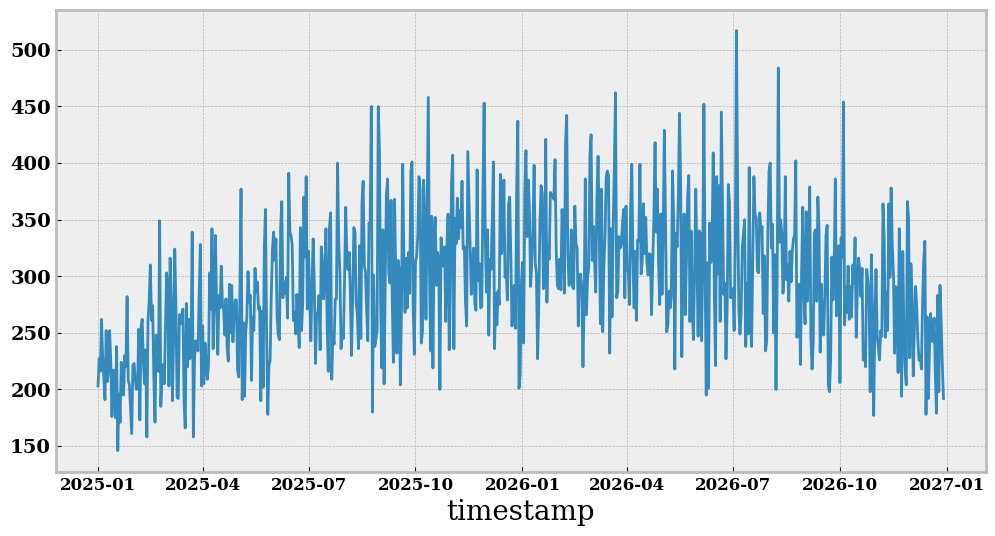

In [6]:
vc = (a1_df)['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc = vc[:-1]
vc.plot(kind='line', figsize=(12, 6))

In [7]:
inject_date_start = date(2025, 5, 1)
inject_date_end = date(2025, 5, 10)
vc[(vc.index >= inject_date_start) & (vc.index <= inject_date_end)] *= 1.5

/tmp/ipykernel_9386/3639505935.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[325.5 316.5 430.5 565.5 286.5 388.5 291.  375.  396.  456. ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  vc[(vc.index >= inject_date_start) & (vc.index <= inject_date_end)] *= 1.5


In [8]:
inject_date_start = date(2026, 3, 5)
inject_date_end = date(2026, 4, 5)
vc[(vc.index >= inject_date_start) & (vc.index <= inject_date_end)] *= 1.25

In [9]:
inject_date_start = date(2025, 10, 22)
inject_date_end = date(2025, 10, 26)
vc[(vc.index >= inject_date_start) & (vc.index <= inject_date_end)] *= 1.8

<Axes: xlabel='timestamp'>

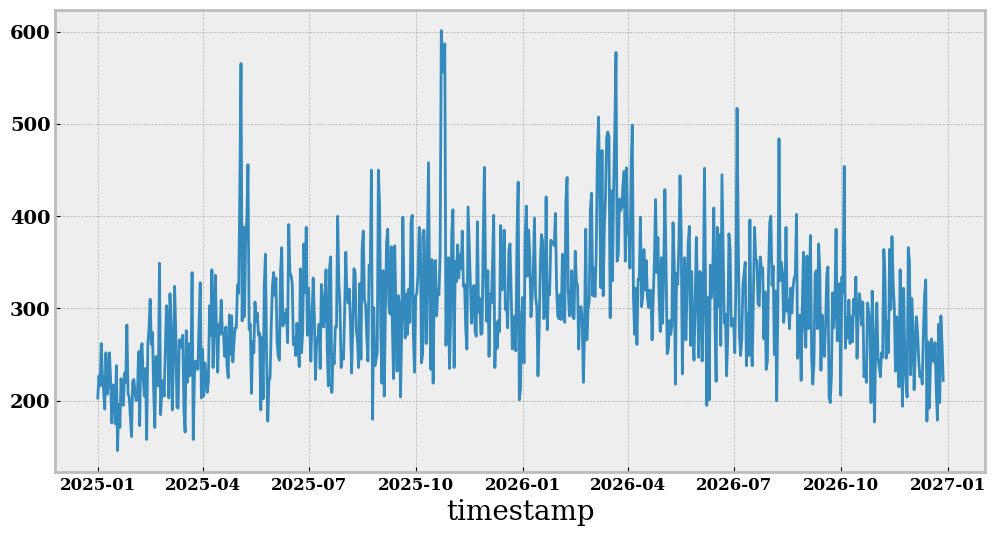

In [10]:
vc = vc[:-1]
vc.plot(kind='line', figsize=(12, 6))

In [11]:
daily = vc.reset_index()
daily.columns = ["ds", "y"]
cap_val = daily['y'].max() * 1.05
daily['cap'] = cap_val
daily["is_weekend"] = df["is_weekend"]


In [12]:
param_grid = {
    "changepoint_prior_scale": [0.001, 0.005, 0.01, 0.05, 0.1],
    "changepoint_range": [0.8, 0.9, 0.95],
    "weekend_prior_scale": [0.1, 1.0, 5.0],
}
all_params = [
    dict(zip(param_grid.keys(), v))
    for v in itertools.product(*param_grid.values())
]

best_rmse = float("inf")
best_model = None
best_params = None

for params in all_params:
    model = Prophet(
        growth="logistic",
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=params["changepoint_prior_scale"],
        changepoint_range=params["changepoint_range"],
    )

    model.add_regressor("is_weekend", prior_scale=params["weekend_prior_scale"])

    model.fit(daily)
    
    df_cv = cross_validation(
        model,
        initial="250 days",
        period="30 days",     
        horizon="90 days"     
    )
    
    df_p = performance_metrics(df_cv, rolling_window=1)
    mean_rmse = df_p['rmse'].mean()
    
    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_model = model 
        best_params = params

print("Best RMSE:", best_rmse)
print("Best params:", best_params)


final_model = Prophet(
    growth="logistic",
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=best_params["changepoint_prior_scale"],
    changepoint_range=best_params["changepoint_range"],
)
final_model.add_regressor("is_weekend", prior_scale=best_params["weekend_prior_scale"])
final_model.fit(daily)

#future = final_model.make_future_dataframe(periods=30)
#future['cap'] = cap_val
forecast = final_model.predict(daily)

fig = model.plot(forecast)
ax = fig.gca()
forecast_line = ax.get_lines()[1]
forecast_line.set_color('red')
forecast_line.set_linewidth(2.)
historical_line = ax.get_lines()[0]
historical_line.set_color('blue')
#historical_line.set_linestyle('-')
historical_line.set_linewidth(1)
for collection in ax.collections:
    collection.set_alpha(0.3)
    collection.set_facecolor('blue')
    collection.set_edgecolor('blue')
plt.plot(daily["ds"], daily["y"], 'o', markersize=4, color="green")
plt.xlabel("date")
plt.ylabel("Streams")

forecast = forecast.copy()
forecast['is_outlier'] = False
forecast['y'] = daily['y']

forecast['y_std'] = (forecast["yhat_upper"] - forecast["yhat_lower"]) / 2

forecast.loc[
    (forecast["y"] > forecast["yhat"] + 2*forecast["y_std"]) |
    (forecast["y"] < forecast["yhat"] - 2*forecast["y_std"]),
    "is_outlier"
] = True
outliers = forecast[forecast["is_outlier"]]

fig = model.plot(forecast)
ax = fig.gca()
forecast_line = ax.get_lines()[1]
forecast_line.set_color('red')
forecast_line.set_linewidth(2.)
historical_line = ax.get_lines()[0]
historical_line.set_color('blue')
#historical_line.set_linestyle('-')
historical_line.set_linewidth(1)
for collection in ax.collections:
    collection.set_alpha(0.3)
    collection.set_facecolor('blue')
    collection.set_edgecolor('blue')
plt.plot(daily["ds"], daily["y"], 'o', markersize=4, color="green")
plt.plot(outliers["ds"], outliers["y"], 'o', markersize=4, color="orange")

upper_2std = forecast["yhat"] + 2*forecast["y_std"]
lower_2std = forecast["yhat"] - 2*forecast["y_std"]

ax.fill_between(
    forecast["ds"],
    lower_2std,
    upper_2std,
    color="red",
    alpha=0.1,
    label="±2×Uncertainty"
)

plt.xlabel("date")
plt.ylabel("Streams")

In [13]:
def find_consecutive_runs(bool_series, min_length=3):
    runs = []
    count = 0
    for i, val in enumerate(bool_series):
        if val:
            count += 1
        else:
            if count >= min_length:
                runs.append((i - count, i - 1))  
            count = 0
    if count >= min_length:
        runs.append((len(bool_series) - count, len(bool_series) - 1))
    return runs

forecast["above_1std"] = forecast["y"] > (forecast["yhat"] + forecast["y_std"])
forecast["below_1std"] = forecast["y"] < (forecast["yhat"] - forecast["y_std"])
above_runs = find_consecutive_runs(forecast["above_1std"], min_length=3)
below_runs = find_consecutive_runs(forecast["below_1std"], min_length=3)

fig = model.plot(forecast)
ax = fig.gca()

forecast_line = ax.get_lines()[1]
forecast_line.set_color('red')
forecast_line.set_linewidth(2.0)
historical_line = ax.get_lines()[0]
historical_line.set_color('blue')
historical_line.set_linewidth(1.0)

for collection in ax.collections:
    collection.set_alpha(0.3)
    collection.set_facecolor('blue')
    collection.set_edgecolor('blue')

ax.plot(forecast["ds"], forecast["y"], 'o', markersize=4, color="green", label="Observed")

for start, end in above_runs:
    ax.axvspan(forecast["ds"].iloc[start], forecast["ds"].iloc[end],
               color='orange', alpha=0.3, label="Detected run")

ax.set_xlabel("Date")
ax.set_ylabel("Streams")
#ax.legend()
fig.autofmt_xdate()
plt.title("Artist 1 Streams")
plt.show()

In [14]:
window = 14
z = 1.96

daily_roll = daily[["ds","y"]].copy().sort_values("ds")
daily_roll["roll_mean"] = daily_roll["y"].rolling(window, min_periods=max(5, window//2)).mean()
daily_roll["roll_std"]  = daily_roll["y"].rolling(window, min_periods=max(5, window//2)).std(ddof=1)
daily_roll["lower"] = daily_roll["roll_mean"] - z*daily_roll["roll_std"]
daily_roll["upper"] = daily_roll["roll_mean"] + z*daily_roll["roll_std"]

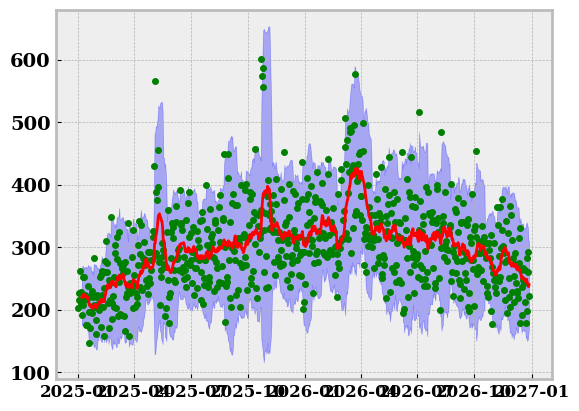

In [15]:
fig = plt.figure()
ax = fig.gca()
ax.plot(daily["ds"], daily["y"], 'o', markersize=4, color="green", label="Observed")
ax.plot(daily_roll["ds"], daily_roll["roll_mean"], color='r')
ax.fill_between(
    daily_roll["ds"],
    daily_roll['lower'],
    daily_roll['upper'],
    color="blue",
    alpha=0.3,
    label="95 % CI"
)

In [16]:
from statsmodels.robust.scale import mad

In [17]:
w = 14
k = 2.5  # tune this like z

daily_rob = daily[["ds","y"]].copy().sort_values("ds")
daily_rob["roll_med"] = daily_rob["y"].rolling(w, min_periods=max(5, w//2)).median()
daily_rob["roll_mad"] = daily_rob["y"].rolling(w, min_periods=max(5, w//2)).apply(
    lambda s: mad(s, c=1.0), raw=False
)
# For normal data, MAD ≈ 0.6745·σ, so σ̂ ≈ MAD/0.6745
sigma_hat = daily_rob["roll_mad"] / 0.6745
daily_rob["lower"] = daily_rob["roll_med"] - k*sigma_hat
daily_rob["upper"] = daily_rob["roll_med"] + k*sigma_hat

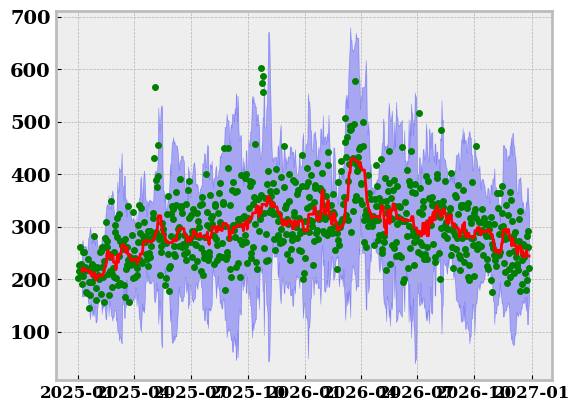

In [18]:
fig = plt.figure()
ax = fig.gca()
ax.plot(daily["ds"], daily["y"], 'o', markersize=4, color="green", label="Observed")
ax.plot(daily_rob["ds"], daily_rob["roll_med"], color='r')
ax.fill_between(
    daily_rob["ds"],
    daily_rob['lower'],
    daily_rob['upper'],
    color="blue",
    alpha=0.3,
    label="95 % CI"
)

In [19]:
import numpy as np

In [20]:
df = daily.copy()       
w = 21           
k = 2.5       

df["baseline_med"] = df["y"].rolling(window=w, min_periods=max(3, w//3), center=True).median()
def rolling_mad(s):
    s = s.dropna()
    if len(s) == 0:
        return np.nan
    return np.median(np.abs(s - np.median(s)))

df["roll_mad"] = df["y"].rolling(window=w, min_periods=max(3, w//3), center=True).apply(
    rolling_mad, raw=False
)

df["sigma_hat"] = df["roll_mad"] / 0.6745
df["upper_med"] = df["baseline_med"] + k * df["sigma_hat"]
df["lower_med"] = df["baseline_med"] - k * df["sigma_hat"]

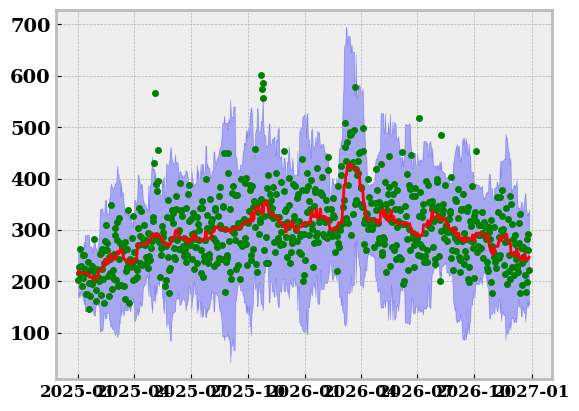

In [21]:
fig = plt.figure()
ax = fig.gca()
ax.plot(df["ds"], df["y"], 'o', markersize=4, color="green", label="Observed")
ax.plot(df["ds"], df["baseline_med"], color='r')
ax.fill_between(
    df["ds"],
    df['lower_med'],
    df['upper_med'],
    color="blue",
    alpha=0.3,
    label="95 % CI"
)

In [22]:
window = 14  # rolling window size
rolling_med = daily["y"].rolling(window, center=True).median()
mad = daily["y"].rolling(window, center=True).apply(lambda x: np.median(np.abs(x - np.median(x))), raw=True)

# Robust bounds (like ~1.5σ)
lower = rolling_med - 2 * mad
upper = rolling_med + 2 * mad

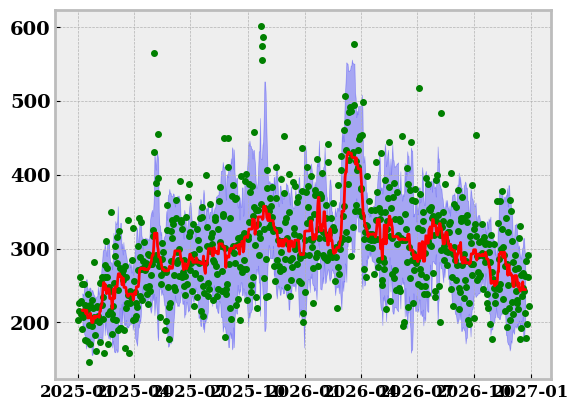

In [23]:
fig = plt.figure()
ax = fig.gca()
ax.plot(daily["ds"], daily["y"], 'o', markersize=4, color="green", label="Observed")
ax.plot(daily["ds"], rolling_med, color='r')
ax.fill_between(
    daily["ds"],
    lower,
    upper,
    color="blue",
    alpha=0.3,
    label="95 % CI"
)

In [24]:
def trimmed_stats(x, trim=0.1):
    x_sorted = np.sort(x)
    n = len(x_sorted)
    k = int(trim * n)
    trimmed = x_sorted[k:n-k]
    mu = np.mean(trimmed)
    sigma = np.std(trimmed, ddof=1)
    return mu, sigma

def trimmed_bounds(x, trim=0.1, z=2):
    mu, sigma = trimmed_stats(x, trim)
    return mu, mu - z*sigma, mu + z*sigma

window = 14
rolling = daily["y"].rolling(window, center=True).apply(
    lambda x: trimmed_bounds(x, trim=0.25, z=2)[0], raw=False
)

lower = daily["y"].rolling(window, center=True).apply(
    lambda x: trimmed_bounds(x, trim=0.25, z=2)[1], raw=False
)
upper = daily["y"].rolling(window, center=True).apply(
    lambda x: trimmed_bounds(x, trim=0.25, z=2)[2], raw=False
)

In [25]:
q_low = daily["y"].rolling(window, center=True).quantile(0.2)
q_med = daily["y"].rolling(window, center=True).quantile(0.5) 
q_high = daily["y"].rolling(window, center=True).quantile(0.8)

In [26]:
import os
import torch
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import matplotlib.pyplot as plt
from pyro.contrib.gp.kernels import Product
import pandas as pd
import torch.nn.functional as F
from pyro.nn import PyroParam
from torch.distributions import constraints
smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.9.1')

In [27]:
X0_old = torch.arange(len(daily)).float()
X0 = X0_old / len(daily)
y0_old = torch.tensor(daily["y"].values).float()
y = torch.tensor(y0_old)
X = torch.tensor(X0)
y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std
y0 = (y0_old - y0_old.mean()) / y0_old.std()
Xend = 1.0

/tmp/ipykernel_9386/2056814068.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y0_old)
/tmp/ipykernel_9386/2056814068.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X0)


In [28]:
def plot(
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=50,
    ax=None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(X.numpy(), y.numpy(), "kx")
    if plot_predictions:
        Xtest = torch.linspace(-0.1, 0.1+Xend, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.1, 0.1+Xend, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(-0.1, 0.1+Xend)

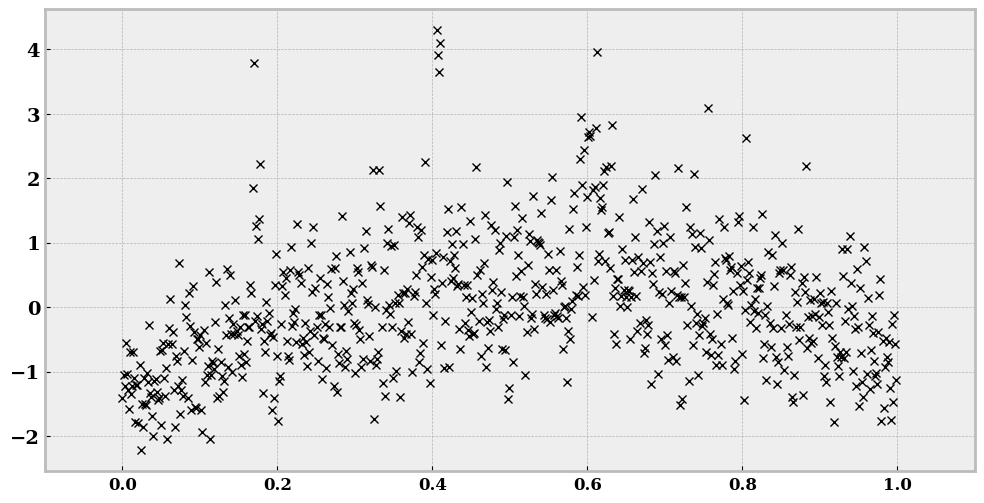

In [29]:
plot(plot_observed_data=True)

In [30]:
n_induced = 80
Xu = torch.linspace(X.min(), X.max(), n_induced)
pyro.clear_param_store()
#rbf_kernel = gp.kernels.RBF(input_dim=1)
#periodic_kernel = gp.kernels.Periodic(input_dim=1, period=torch.tensor(1.))
#kernel = Product(rbf_kernel, periodic_kernel)
#kernel = rbf_kernel
kernel = gp.kernels.Matern52(input_dim=1)
kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.), torch.tensor(0.2)))
kernel.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.0), torch.tensor(1.)))

sgpr = gp.models.SparseGPRegression(X, y, kernel, Xu=Xu, jitter=1.0e-3)
sgpr.noise = pyro.nn.PyroSample(dist.LogNormal(0.0, 0.5))

optimizer = torch.optim.Adam(sgpr.parameters(), lr=1.e-3)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
locations = []
noises = []
num_steps = 1500
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(sgpr.model, sgpr.guide)
    locations.append(sgpr.Xu.data.numpy().copy())
    noises.append(sgpr.noise.item())
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

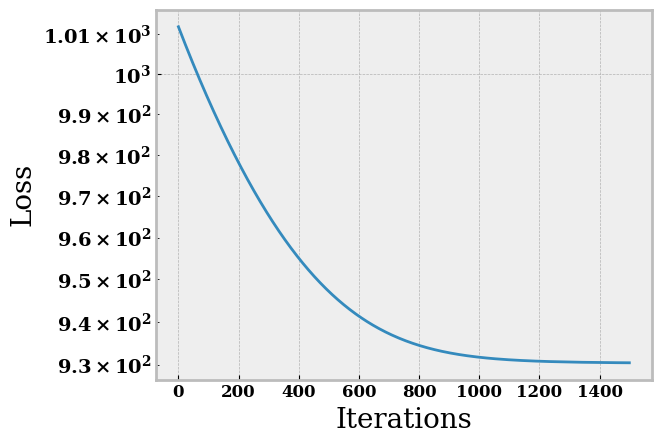

In [31]:
def plot_loss(loss):
    plt.plot(loss)
    plt.yscale('log')
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text


plot_loss(losses)

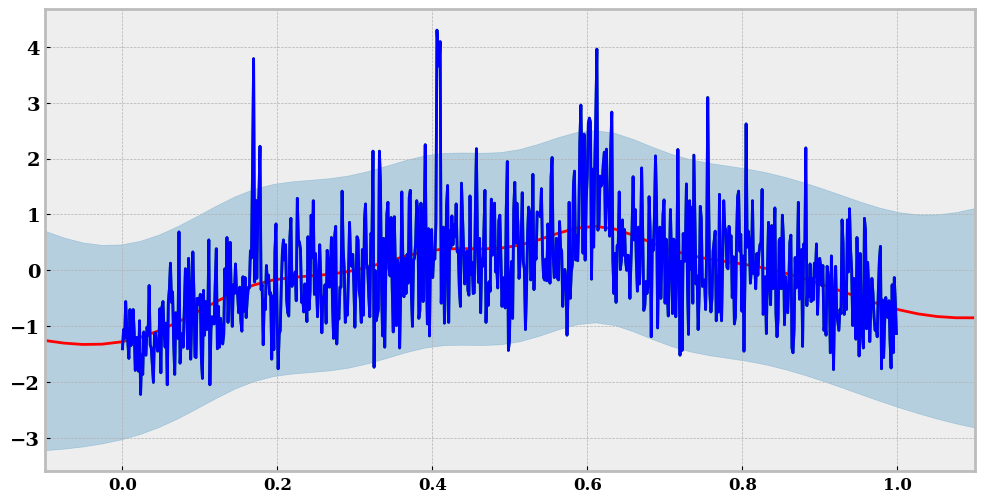

In [32]:
plot(model=sgpr, plot_observed_data=False, plot_predictions=True)
plt.plot(X0,y0, 'g')
plt.plot(X,y, 'b')

In [33]:
mean, cov = sgpr(X0, full_cov=True)
y_rescaled = y_std * mean + y_mean

In [34]:
df_base = pd.DataFrame(data = {'day': pd.Series(X0_old),
                        'y':pd.Series(y0_old),
                        'y_base': pd.Series(y_rescaled.detach().numpy())})

In [35]:
from scipy.stats import mstats

In [36]:
def rolling_trimmed_mad(series, window=21, trim_frac=0.1, min_periods=5):
    """
    For each rolling window:
      - winsorize top/bottom `trim_frac` fraction,
      - compute mad of the winsorized window,
      - return mad (not sigma).
    """
    def fn(arr):
        a = np.array(arr)
        if np.isnan(a).all():
            return np.nan
        # winsorize (limits=(trim_frac, trim_frac)) then MAD
        try:
            w = mstats.winsorize(a, limits=(trim_frac, trim_frac))
        except Exception:
            w = a  # fallback
        med = np.median(w)
        return np.median(np.abs(w - med))
    return series.rolling(window=window, center=True, min_periods=min_periods).apply(fn, raw=False)

# Example: df with columns ds, y, baseline_combo computed earlier
w = 100
trim_frac = 0.1
df_base = df_base.sort_values("day").copy()
df_base['resid'] = df_base['y'] - df_base['y_base']
df_base['roll_mad_trim'] = rolling_trimmed_mad(df_base['resid'], window=w, trim_frac=trim_frac)

df_base['sigma_hat'] = df_base['roll_mad_trim'] / 0.6745
df_base['lower_1'] = df_base['y_base'] - df_base['sigma_hat']
df_base['upper_1'] = df_base['y_base'] + df_base['sigma_hat']
df_base['lower_2'] = df_base['y_base'] - 2*df_base['sigma_hat']
df_base['upper_2'] = df_base['y_base'] + 2*df_base['sigma_hat']

df_base['day_date'] = daily['ds']

/home/frang/miniconda3_linux/envs/arxiv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:820: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [37]:
df_base["above_1x"] = df_base["y"] > (df_base["upper_1"])
above_runs_1 = find_consecutive_runs(df_base["above_1x"], min_length=5)

df_base["above_2x"] = df_base["y"] > (df_base["upper_2"])
above_runs_2 = find_consecutive_runs(df_base["above_2x"], min_length=3)

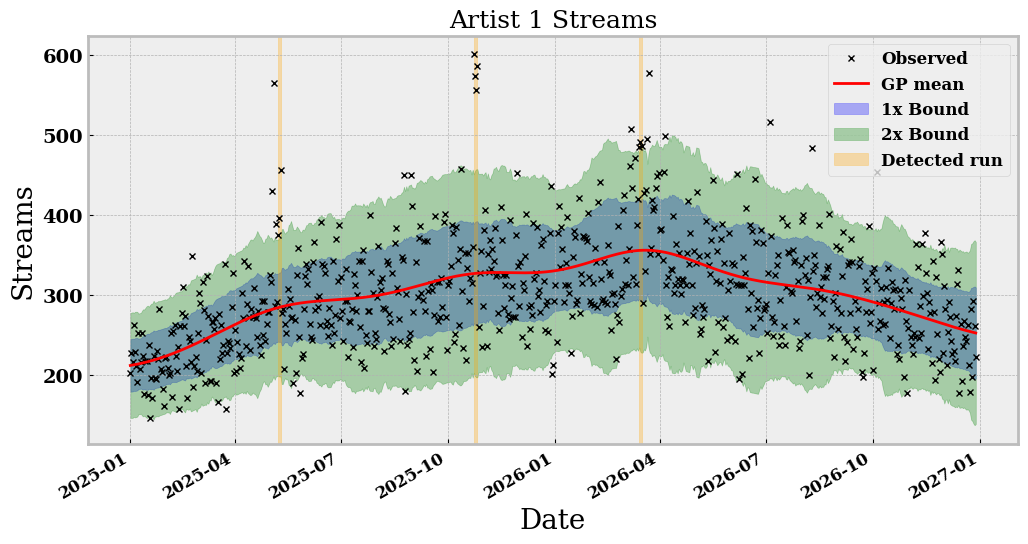

In [38]:
fig = plt.figure(figsize=(12, 6))
ax = fig.gca()
ax.plot(df_base['day_date'], df_base["y"], "kx", markersize=4, label="Observed")
ax.plot(df_base['day_date'], df_base["y_base"], color='r', label='GP mean')

ax.fill_between(
    df_base['day_date'],
    df_base['lower_1'],
    df_base['upper_1'],
    color="blue",
    alpha=0.3,
    label="1x Bound"
)

ax.fill_between(
    df_base['day_date'],
    df_base['lower_2'],
    df_base['upper_2'],
    color="green",
    alpha=0.3,
    label="2x Bound"
)

for i, (start, end) in enumerate(above_runs_1):
    if i==0:
        ax.axvspan(df_base["day_date"].iloc[start], df_base["day_date"].iloc[end],
               color='yellow', alpha=0.3, label="Detected run")
    else:
        ax.axvspan(df_base["day_date"].iloc[start], df_base["day_date"].iloc[end],
               color='yellow', alpha=0.3)
    
for i, (start, end) in enumerate(above_runs_2):
    if i==0:
        ax.axvspan(df_base["day_date"].iloc[start], df_base["day_date"].iloc[end],
               color='orange', alpha=0.3, label="Detected run")
    else:
        ax.axvspan(df_base["day_date"].iloc[start], df_base["day_date"].iloc[end],
               color='orange', alpha=0.3)

plt.title("Artist 1 Streams")
ax.set_xlabel("Date")
ax.set_ylabel("Streams")
ax.legend()
fig.autofmt_xdate()

In [39]:
import importlib
import plot_params


importlib.reload(plot_params)
plot_params.apply_rcparams()

In [44]:
pd.to_pickle(df_base, "../data/time_series.pkl")

In [41]:
df_base.head()

,day,y,y_base,resid,roll_mad_trim,sigma_hat,lower_1,upper_1,lower_2,upper_2,day_date,above_1x,above_2x
0,0.0,203.0,211.914673,-8.914673,22.083290,32.740237,179.174435,244.654910,146.434198,277.395148,2025-01-01,False,False
1,1.0,227.0,212.165375,14.834625,22.224197,32.949144,179.216231,245.114518,146.267087,278.063662,2025-01-02,False,False
2,2.0,216.0,212.424805,3.575195,22.285591,33.040165,179.384640,245.464969,146.344475,278.505134,2025-01-03,False,False
3,3.0,262.0,212.693268,49.306732,21.913925,32.489140,180.204127,245.182408,147.714987,277.671549,2025-01-04,True,False
4,4.0,229.0,212.970428,16.029572,22.285591,33.040165,179.930264,246.010593,146.890099,279.050758,2025-01-05,False,False
